In [8]:
import numpy as np
import h5py
import cv2
FILE_PATH = r"C:\VisualOdometry\falcon_indoor_flight_1_data.h5"

In [ ]:
with h5py.File(FILE_PATH, "r") as file:
    w, h = list(file["prophesee"]["left"]["calib"]["resolution"])
    distortion_coeffs_left = list(file["prophesee"]["left"]["calib"]["distortion_coeffs"])
    fx, fy, cx, cy = (list(file["prophesee"]["left"]["calib"]["intrinsics"]))
    K_left = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    distortion_coeffs_right = list(file["prophesee"]["right"]["calib"]["distortion_coeffs"])
    fx, fy, cx, cy = (list(file["prophesee"]["right"]["calib"]["intrinsics"]))
    K_right = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    distortion_coeffs_rgb = (list(file["ovc"]["rgb"]["calib"]["distortion_coeffs"]))
    fx, fy, cx, cy = list(file["ovc"]["rgb"]["calib"]["intrinsics"])
    T_rgb = (list(file["ovc"]["rgb"]["calib"]["T_to_prophesee_left"]))
    T_rgb = np.array(T_rgb)
    K_rgb = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [10]:
def event_generator(file_path, cam_direction="left", batch_size=1024):
    with h5py.File(file_path, "r") as file:
        x = file["prophesee"][cam_direction]["x"]
        y = file["prophesee"][cam_direction]["y"]
        p = file["prophesee"][cam_direction]["p"]
        t = file["prophesee"][cam_direction]["t"]
        total = x.shape[0]
        for i in range(0, total, batch_size):
            yield (
                x[i : i + batch_size],
                y[i : i + batch_size],
                p[i : i + batch_size],
                t[i : i + batch_size],
            )

In [11]:
def event_frame(coords, polarities, img_shape):
    matrix = np.ones(img_shape, dtype=np.uint8) * 127
    coords = np.array(coords)
    if len(coords) > 0:
        y = coords[:, 0]
        x = coords[:, 1]
        matrix[y, x] = np.where(np.array(polarities) > 0, 255, 0)
    return matrix

In [108]:
prev_img = None
cur_R = np.eye(3)
cur_t = np.zeros((3, 1))
trajectory_3d = []


def odom(picture, K):
    global prev_img, cur_R, cur_t, trajectory_3d

    if len(picture.shape) == 3:
        gray = cv2.cvtColor(picture, cv2.COLOR_BGR2GRAY)
    else:
        gray = picture.copy()

    fast = cv2.FastFeatureDetector_create(threshold=75, nonmaxSuppression=True)
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    if prev_img is None:
        prev_img = gray
        return cur_t.copy()

    kp1 = fast.detect(prev_img, None)
    kp2 = fast.detect(gray, None)
    if len(kp1) < 10 or len(kp2) < 10:
        prev_img = gray
        return cur_t.copy()

    kp1, des1 = brief.compute(prev_img, kp1)
    kp2, des2 = brief.compute(gray, kp2)
    if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
        prev_img = gray
        return cur_t.copy()

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < 8:
        prev_img = gray
        return cur_t.copy()

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    E, mask = cv2.findEssentialMat(
        pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
    )
    if E is None:
        prev_img = gray
        return cur_t.copy()

    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

    cur_t += cur_R @ t
    cur_R = R @ cur_R

    trajectory_3d.append(cur_t.flatten().copy())

    prev_img = gray
    return cur_t.copy()

In [7]:
cnt = 1
batch_idx = 0
temp_x, temp_y, temp_p, temp_t = [], [], [], []
prev_img = None
cur_R = np.eye(3)
cur_t = np.zeros((3, 1))
trajectory_3d = []
exit = False

for x_batch, y_batch, p_batch, t_batch in event_generator(
    FILE_PATH, "left", batch_size=10000
):
    batch_idx += 1
    if batch_idx % 25 != 0:
        continue

    temp_x.extend(x_batch)
    temp_y.extend(y_batch)
    temp_p.extend(np.where(p_batch > 0, 1, -1))
    temp_t.extend(t_batch)

    while len(temp_t) > 0 and temp_t[-1] > cnt * 1e5:
        cnt += 1
        coords = list(zip(temp_y, temp_x))
        img = event_frame(coords, temp_p, (h, w))

        odom(img, K_left)
        cv2.imshow("Event Frame", img)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            exit = True
            break
        temp_x.clear()
        temp_y.clear()
        temp_p.clear()
        temp_t.clear()
    if exit:
        break

cv2.destroyAllWindows()

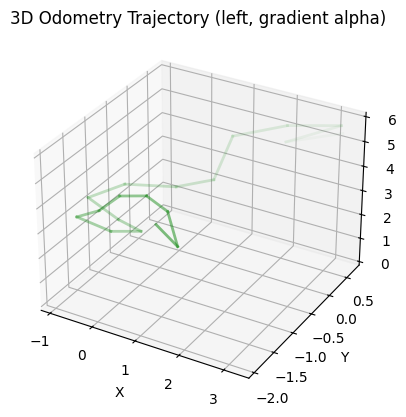

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

if len(trajectory_3d) > 1:
    trajectory_3d_np = np.array(trajectory_3d)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    n = len(trajectory_3d_np)
    for i in range(n - 1):
        alpha = 0.8 * (1 - i / (n - 1))
        ax.plot(
            trajectory_3d_np[i : i + 2, 0],
            trajectory_3d_np[i : i + 2, 1],
            trajectory_3d_np[i : i + 2, 2],
            color="g",
            alpha=alpha,
            linewidth=2,
        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Odometry Trajectory (left, gradient alpha)")
    plt.show()

In [109]:
prev_img = None
cur_R = np.eye(3)
cur_t = np.zeros((3, 1))
trajectory_3d = []
with h5py.File(FILE_PATH, "r") as file:
    rgb_dataset = file["ovc"]["rgb"]["data"]
    num_images = rgb_dataset.shape[0]
    # 150
    for i in range(150,num_images-60):
        rgb = rgb_dataset[i]
        rgb = np.array(rgb, dtype=np.uint8)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        odom(gray, K_rgb)
        cv2.imshow("Grayscale OVC Image", gray)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cv2.destroyAllWindows()

In [110]:
import plotly.graph_objs as go
import numpy as np

trajectory_3d_np = np.array(trajectory_3d)
trajectory_3d_np = trajectory_3d_np[::5]
fig = go.Figure()

n = len(trajectory_3d_np)
for i in range(n - 1):
    alpha = 0.8 * (1 - i / (n - 1)) 
    fig.add_trace(
        go.Scatter3d(
            x=-trajectory_3d_np[i : i + 2, 0],
            y=trajectory_3d_np[i : i + 2, 1],
            z=-trajectory_3d_np[i : i + 2, 2],
            mode="lines",
            line=dict(color="green", width=4),
            opacity=alpha,
            showlegend=False,
        )
    )

fig.update_layout(
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    title="3D Odometry Trajectory rgb (gradient alpha)",
)
fig.show()

In [103]:
import plotly.graph_objs as go
import numpy as np

gt_file = r"C:\VisualOdometry\falcon_indoor_flight_1_pose_evo_gt.txt"
gt_positions = []
with open(gt_file, "r") as f:
    for line in f:
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split()
        tx, ty, tz = map(float, parts[1:4])
        gt_positions.append([tx, ty, tz])
gt_positions = np.array(gt_positions)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=gt_positions[:, 0],
            y=gt_positions[:, 1],
            z=gt_positions[:, 2],
            mode="lines",
            line=dict(color="red", width=4),
        )
    ]
)
fig.update_layout(
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    title="3D Ground Truth Trajectory",
)
fig.show()